### Solutions to Tasks in Stochastic Simulation Algorithm Notebook
These are not unique and if you approached the problem a different way, that's great!


### Task 1:
In the setup, change the line `N=3` to the size of the ensemble you would like.

### Task 2:
In class, we studied the reaction network
$$A + B -> 2B$$
$$B -> A$$  We can write this as a compartment ODE model
$$ \frac{dA}{dt} = -k_1 A + k_2 B$$
$$ \frac{dB}{dt} = k_1 A - k_2 B$$
where $A$ and $B$ represent concentrations of the molecules.
We plot the solution with a given initial condition below and note that it looks a lot like the mean in the stochastic model.


In [1]:
import numpy as np # Numerical computing library
import matplotlib.pyplot as plt # Plotting library
import scipy.integrate # Integration library
from scipy.integrate import odeint # function to solve ODEs numerically

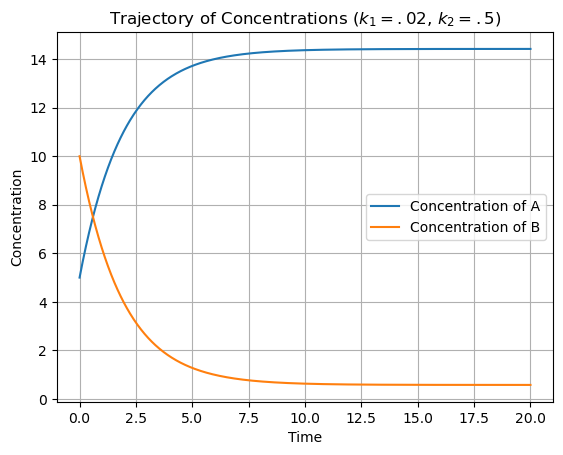

In [2]:
def rxn_network(y,t):
    """ODE system modeling rxn network A + B -> 2B, B -> A
    Args:
    y (array): (concentration of A, concentration of B)
    t (float): time
    Return: dy/dt"""
    k1 = 0.02   # rate for A + B -> A + 2B
    k2 = 0.5    # rate for B -> A
    A, B = y 
    return np.array([- k1 * A + k2 * B ,
                     k1 * A - k2 * B])

# Initial condition and time span
initial_condition = (5, 10)
time = np.linspace(0, 20, 1000)

# Solve the ODE
# form is scipy.integrate.odeint(func, y0, t, args=(), ...) 
# where func defines the RHS of the system of ODEs, y0 is initial condition
# t is array of time points where solution is computed
# args optional tuple
solution = scipy.integrate.odeint(rxn_network, y0=initial_condition, t=time)

# Plot the results
plt.plot(time, solution[:, 0], label='Concentration of A')
plt.plot(time, solution[:, 1], label='Concentration of B')
plt.xlabel('Time')
plt.ylabel('Concentration')
# the r makes strings raw so I can use LaTex math mode to write alpha, beta in greek
plt.title('Trajectory of Concentrations ($k_1=.02$, $k_2=.5$)')
plt.legend()
plt.grid(True)
# save as a pdf if you need the image file for Overleaf, etc.
plt.savefig("rxn.pdf")
# see plot in notebook
plt.show()

### Task 3:
Prompt: We previously studied the SIR model in a deterministic framework.  Recast this into a stochastic framework and alter the code above to use the SSA for the SIR model.  It is enough to track just $S$ and $I$ and the two reactions you consider will be infection and recovery.  Let the stochastic transmission parameter be $\alpha=.2$ and the stochastic recovery parameter be $\beta=.01$, and let the initial condition be $S(0)=90$, $I(0)=10$.
Approach: 
- We need to write out the stochiometry vectors for each reaction: $\bf{s_1}=(-1,1)$ and $\bf{s_2}=(0,-1)$
- We need to write out hte propensities, which depend on the state of the system: $a_1 = \alpha m n$ and $a_2 = \beta n$ where $m$ is the number of susceptible in the state and $n$ is the number of infected in the state.
- We will implement the SSA with this information and the given parameters and ICs by modifying the code in the example for the reaction network in the original example.

#### Set up and initial state

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
# --- Parameters ---
alpha = 0.2   # transmission parameter
beta = 0.01    # recovery parameter

N  = 3      # ensemble size (how many samples we want to generate)
Tsteps = 70 # number of reaction events (steps) to simulate per trajectory

# --- Initial conditions ---
S0 = 90     # start with 90 susceptible
I0 = 10     # start with 10 infected

#### Storage


In [5]:
# --- Storage: rows = step index (including step 0), cols = ensemble member ---
S = np.zeros((Tsteps, N), dtype=int) # counts are integers
I = np.zeros((Tsteps, N), dtype=int)
t = np.zeros((Tsteps, N), dtype=float) # times of reaction are floats

S[0, :] = S0
I[0, :] = I0
t[0, :] = 0.0

#### SSA
Update previous example by replacing the propensities and stochiometry vectors (how the state is updated if the reaction fires).

In [6]:
 # --- Gillespie SSA over the ensemble ---
EPS = 1e-15  # tiny guard against numerical zero

for j in range(N):  # loop through trajectories
    for i in range(Tsteps - 1):  # loop through events
        nS, nI = S[i, j], I[i, j] # get number of susceptible and number of infected

        # propensities given current state 
        a1 = alpha * nS * nI   # S + I -> 2I 
        a2 = beta * nI         # I -> R   
        atot = a1 + a2         # total propensity

        # if no reactions are possible, freeze the rest of this trajectory
        if atot <= EPS:
            S[i+1:, j] = nS
            I[i+1:, j] = nI
            t[i+1:, j] = t[i, j]
            break

        # --- choose which reaction fires ---
        p1 = a1 / atot         # safe because atot > EPS
        u  = random.random()   # U ~ Uniform(0,1)

        if u < p1:
            # Reaction 1: S + I -> 2I  (lose one S, gain one I; guard at zero)
            S[i+1, j] = max(nS - 1, 0) # don't let count become negative
            I[i+1, j] = nI + 1
        else:
            # Reaction 2: I -> R  (no change in S, lose one I; guard at zero)
            S[i+1, j] = nS 
            I[i+1, j] = max(nI - 1, 0) # don't let count become negative

        # --- draw waiting time to next reaction ---
        tau = np.random.exponential(1 / atot)  # Exp(atot)
        t[i+1, j] = t[i, j] + tau


#### Plot trajectories of ensemble

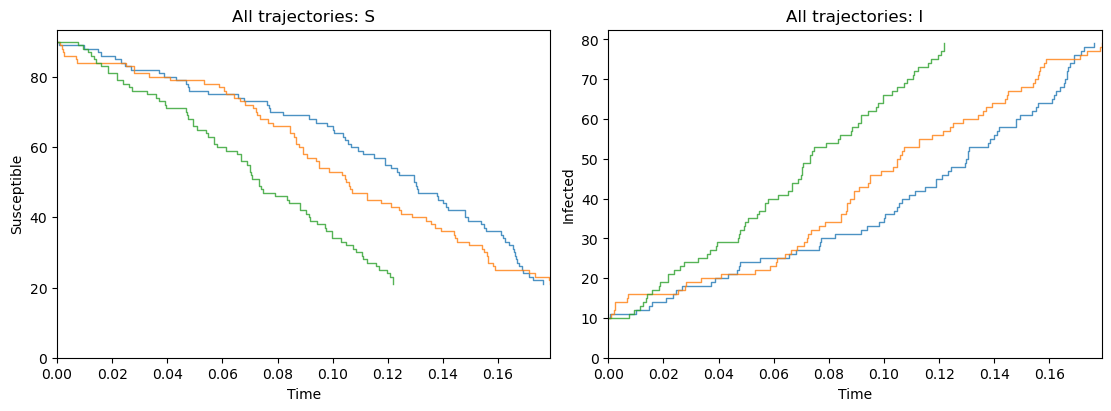

In [8]:
# --- Plot ALL trajectories ---
fig, (axS_all, axI_all) = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

for j in range(N):
    axS_all.step(t[:, j], S[:, j], where='post', lw=1, alpha=0.8)
    axI_all.step(t[:, j], I[:, j], where='post', lw=1, alpha=0.8)

# nice axes (use ensemble-wide max time)
tmax_all = np.max(t)
axS_all.set_xlim(0, tmax_all); axI_all.set_xlim(0, tmax_all)
axS_all.set_ylim(bottom=0);    axI_all.set_ylim(bottom=0)

axS_all.set_xlabel('Time'); axS_all.set_ylabel('Susceptible'); axS_all.set_title('All trajectories: S')
axI_all.set_xlabel('Time'); axI_all.set_ylabel('Infected'); axI_all.set_title('All trajectories: I')

plt.show()

### Task 4
Prompt: Consider the SIR model but now with vaccination (moving a susceptible directly into the recovered compartment.  Let the stochastic rate constant for vaccination be $\nu=.05$.  Repeat the problem from above with the same initial conditions and parameter values.  (Hint: much will be the same, but now instead of choosing from 2 reactions, you will choose from 3.)
- in Python if you want to compare more than 2 cases, rather than `if`/`else`, use `if`/`elif`/`else`.

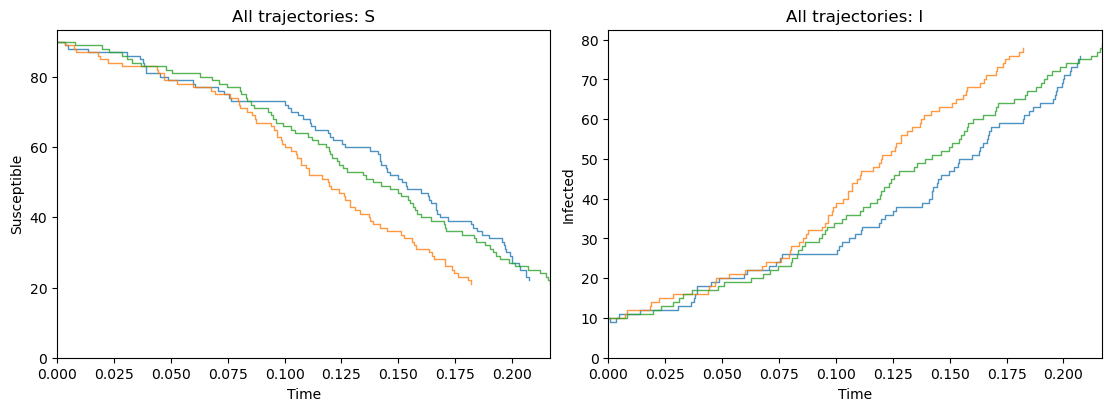

In [9]:
# --- Parameters ---
alpha = 0.2   # transmission parameter
beta = 0.01    # recovery parameter
nu = .05    # vaccination parameter

N  = 3      # ensemble size (how many samples we want to generate)
Tsteps = 70 # number of reaction events (steps) to simulate per trajectory

# --- Initial conditions ---
S0 = 90     # start with 90 susceptible
I0 = 10     # start with 10 infected

# --- Storage: rows = step index (including step 0), cols = ensemble member ---
S = np.zeros((Tsteps, N), dtype=int) # counts are integers
I = np.zeros((Tsteps, N), dtype=int)
t = np.zeros((Tsteps, N), dtype=float) # times of reaction are floats

S[0, :] = S0
I[0, :] = I0
t[0, :] = 0.0

 # --- Gillespie SSA over the ensemble ---
EPS = 1e-15  # tiny guard against numerical zero

for j in range(N):  # loop through trajectories
    for i in range(Tsteps - 1):  # loop through events
        nS, nI = S[i, j], I[i, j] # get number of susceptible and number of infected

        # propensities given current state 
        a1 = alpha * nS * nI   # S + I -> 2I 
        a2 = beta * nI         # I -> R   
        a3 = nu * nS
        atot = a1 + a2 + a3        # total propensity

        # if no reactions are possible, freeze the rest of this trajectory
        if atot <= EPS:
            S[i+1:, j] = nS
            I[i+1:, j] = nI
            t[i+1:, j] = t[i, j]
            break

        # --- choose which reaction fires --- there are now 3 to choose from
        p1 = a1 / atot         # safe because atot > EPS
        p2 = a2 / atot
        u  = random.random()   # U ~ Uniform(0,1)

        if u < p1:
            # Reaction 1: S + I -> 2I  (lose one S, gain one I; guard at zero)
            S[i+1, j] = max(nS - 1, 0) # don't let count become negative
            I[i+1, j] = nI + 1
        elif u < p1 + p2:
            # Reaction 2: I -> R  (no change in S, lose one I; guard at zero)
            S[i+1, j] = nS 
            I[i+1, j] = max(nI - 1, 0) # don't let count become negative
            
        else:
            # Reaction 3: S -> R  (lose one S, no change in I; guard at zero)
            S[i+1, j] = max(nS - 1, 0) 
            I[i+1, j] = nI

        # --- draw waiting time to next reaction ---
        tau = np.random.exponential(1 / atot)  # Exp(atot)
        t[i+1, j] = t[i, j] + tau
        
# --- Plot ALL trajectories ---
fig, (axS_all, axI_all) = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

for j in range(N):
    axS_all.step(t[:, j], S[:, j], where='post', lw=1, alpha=0.8)
    axI_all.step(t[:, j], I[:, j], where='post', lw=1, alpha=0.8)

# nice axes (use ensemble-wide max time)
tmax_all = np.max(t)
axS_all.set_xlim(0, tmax_all); axI_all.set_xlim(0, tmax_all)
axS_all.set_ylim(bottom=0);    axI_all.set_ylim(bottom=0)

axS_all.set_xlabel('Time'); axS_all.set_ylabel('Susceptible'); axS_all.set_title('All trajectories: S')
axI_all.set_xlabel('Time'); axI_all.set_ylabel('Infected'); axI_all.set_title('All trajectories: I')

plt.show()

### Task 5:
Play with the value of $\nu$.

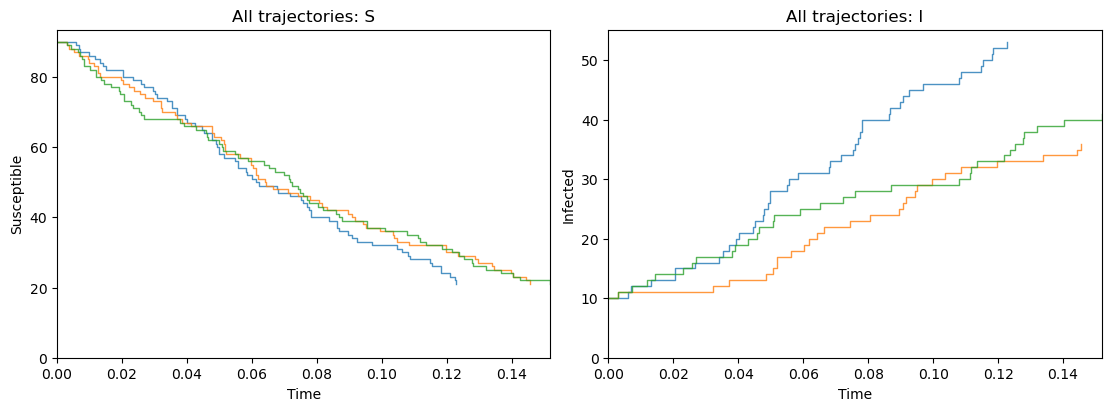

In [10]:
# --- Parameters ---
alpha = 0.2   # transmission parameter
beta = 0.01    # recovery parameter
nu = 5    # vaccination parameter

N  = 3      # ensemble size (how many samples we want to generate)
Tsteps = 70 # number of reaction events (steps) to simulate per trajectory

# --- Initial conditions ---
S0 = 90     # start with 90 susceptible
I0 = 10     # start with 10 infected

# --- Storage: rows = step index (including step 0), cols = ensemble member ---
S = np.zeros((Tsteps, N), dtype=int) # counts are integers
I = np.zeros((Tsteps, N), dtype=int)
t = np.zeros((Tsteps, N), dtype=float) # times of reaction are floats

S[0, :] = S0
I[0, :] = I0
t[0, :] = 0.0

 # --- Gillespie SSA over the ensemble ---
EPS = 1e-15  # tiny guard against numerical zero

for j in range(N):  # loop through trajectories
    for i in range(Tsteps - 1):  # loop through events
        nS, nI = S[i, j], I[i, j] # get number of susceptible and number of infected

        # propensities given current state 
        a1 = alpha * nS * nI   # S + I -> 2I 
        a2 = beta * nI         # I -> R   
        a3 = nu * nS
        atot = a1 + a2 + a3        # total propensity

        # if no reactions are possible, freeze the rest of this trajectory
        if atot <= EPS:
            S[i+1:, j] = nS
            I[i+1:, j] = nI
            t[i+1:, j] = t[i, j]
            break

        # --- choose which reaction fires --- there are now 3 to choose from
        p1 = a1 / atot         # safe because atot > EPS
        p2 = a2 / atot
        u  = random.random()   # U ~ Uniform(0,1)

        if u < p1:
            # Reaction 1: S + I -> 2I  (lose one S, gain one I; guard at zero)
            S[i+1, j] = max(nS - 1, 0) # don't let count become negative
            I[i+1, j] = nI + 1
        elif u < p1 + p2:
            # Reaction 2: I -> R  (no change in S, lose one I; guard at zero)
            S[i+1, j] = nS 
            I[i+1, j] = max(nI - 1, 0) # don't let count become negative
            
        else:
            # Reaction 3: S -> R  (lose one S, no change in I; guard at zero)
            S[i+1, j] = max(nS - 1, 0) 
            I[i+1, j] = nI

        # --- draw waiting time to next reaction ---
        tau = np.random.exponential(1 / atot)  # Exp(atot)
        t[i+1, j] = t[i, j] + tau
# --- Plot ALL trajectories  ---
fig, (axS_all, axI_all) = plt.subplots(1, 2, figsize=(11, 4), constrained_layout=True)

for j in range(N):
    axS_all.step(t[:, j], S[:, j], where='post', lw=1, alpha=0.8)
    axI_all.step(t[:, j], I[:, j], where='post', lw=1, alpha=0.8)

# nice axes (use ensemble-wide max time)
tmax_all = np.max(t)
axS_all.set_xlim(0, tmax_all); axI_all.set_xlim(0, tmax_all)
axS_all.set_ylim(bottom=0);    axI_all.set_ylim(bottom=0)

axS_all.set_xlabel('Time'); axS_all.set_ylabel('Susceptible'); axS_all.set_title('All trajectories: S')
axI_all.set_xlabel('Time'); axI_all.set_ylabel('Infected'); axI_all.set_title('All trajectories: I')

plt.show()